TEM CNN

In [35]:
import os
import sys
import importlib
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import to_categorical
import pandas as pd

notebooks_dir = os.path.abspath('')
proj_dir = os.path.dirname(notebooks_dir)
raw_data_dir = os.path.join(proj_dir, 'raw_data')
src_dir = os.path.join(proj_dir, 'src')

# Add src_dir to the system path to import helper file
sys.path.insert(1, src_dir)
#import cutpaste_helper
#importlib.reload(cutpaste_helper)

def makeWindows(image_dict,num_windows, width, height):
    '''
    Parameters:
    image_dict: dictionary containing arrays that represent images
    num_windows: the number of windows wanted
    width: the width of the window
    height: the height of the window
    '''
    
    #store the coordinates of the defective window
    
    #Grab windows from the full images from train images
    window_images = []
    for key in image_dict:
    #The 100 windows per image in a list
        for i in range(0, num_windows):
            #Get the width and height of an image
            dimensions = image_dict[key].shape
            image_w = dimensions[1]
            image_h = dimensions[0]
            #Random coordinates
            random_x_coord = random.randint(0, image_w - width)
            random_y_coord = random.randint(0, image_h-height)
            #Takes window out of a random part of the images at the random coordinates
            window = image_dict[key][random_y_coord:random_y_coord + window_y, random_x_coord:random_x_coord + window_x]
            window_images.append(window)
    window_images = np.array(window_images)
    return window_images

def makeDefects(window_list):
    #Create test window images dict with white square defects
    defect_window_list = np.copy(window_list)
#Fill defect train window images
    for image in defect_window_list:
        #Random sized white square (2D array full of ones)
        sq_random_x = random.randint(5,25)
        sq_random_y = random.randint(5,25)
        white_square = np.ones((sq_random_y,sq_random_x))
        #Random coordinates for the square
        random_x_coord = random.randint(0,window_x-sq_random_x)
        random_y_coord = random.randint(0,window_y-sq_random_y)
        #Replace the coordinates with white square
        image[random_y_coord:random_y_coord + sq_random_y, random_x_coord: random_x_coord + sq_random_x,0] = white_square
    return defect_window_list

def copyPaste(window_list):
    defect_window_list = np.copy(window_list)
    #Fill defect train window images
    for window in defect_window_list:
        #Random sized copy-pasted area (2D array)
        sq_random_x = random.randint(5,25)
        sq_random_y = random.randint(5,25)
        #Random coordinates for the square
        random_x_coord = random.randint(0,window.shape[1]-sq_random_x)
        random_y_coord = random.randint(0,window.shape[0]-sq_random_y)
        #Copy the area
        copyArea = window[random_y_coord:random_y_coord + sq_random_y, random_x_coord: random_x_coord + sq_random_x,0]
        #Paste coordinates
        random_x_coord = random.randint(0,window_x-sq_random_x)
        random_y_coord = random.randint(0,window_y-sq_random_y)
        #Paste the area
        window[random_y_coord:random_y_coord + sq_random_y, random_x_coord: random_x_coord + sq_random_x,0] = copyArea
    return defect_window_list

def createLabels(image_list, defect_status):
    labels_list = []

    for image in image_list:
        if defect_status:
            labels_list.append(1)
        else:
            labels_list.append(0)
    labels_list = np.array(labels_list)
    return labels_list
        
def shuffleTwoArrays(image_list, label_list):
    randomize = np.arange(len(label_list))
    np.random.shuffle(randomize)
    image_list = image_list[randomize]
    label_list = label_list[randomize]
    return (image_list, label_list)
    
# Load dictionaries with TEM images
f_name = os.path.join(raw_data_dir, 'test_full_arrays')
#Dict with test image arrays (each key has a value of an array of numbers between 0 and 1)
test_full_arrays = pickle.load(open(f_name, "rb"))
f_name = os.path.join(raw_data_dir, 'train_full_arrays')
#Dict with train image arrays (each key has a value of an array of numbers between 0 and 1)
train_full_arrays = pickle.load(open(f_name, "rb"))

window_x = 118
window_y = 84
num_windows = 100

#Make testing window images and labels
test_window_images = makeWindows(test_full_arrays, num_windows, window_x, window_y)
test_window_labels = createLabels(test_window_images, False)

#Make training window images and labels
train_window_images = makeWindows(train_full_arrays, num_windows ,window_x, window_y)
train_window_labels = createLabels(train_window_images, False)

#Make defect testing window images and labels
defect_test_window_images = copyPaste(test_window_images)
defect_test_window_labels = createLabels(defect_test_window_images, True)

#Make defect training window images and labels
defect_train_window_images = copyPaste(train_window_images)
defect_train_window_labels = createLabels(defect_train_window_images, True)
        
#Put all testing & training images and labels in one list each and making them random
all_training_images = np.concatenate((train_window_images, defect_train_window_images), axis = 0)
all_training_labels = np.concatenate((train_window_labels, defect_train_window_labels), axis = 0)
training_images, training_labels = shuffleTwoArrays(all_training_images, all_training_labels)
all_testing_images = np.concatenate((test_window_images, defect_test_window_images), axis = 0)
all_testing_labels = np.concatenate((test_window_labels, defect_test_window_labels), axis = 0)
testing_images, testing_labels = shuffleTwoArrays(all_testing_images, all_testing_labels)

#Stuff
filters = [4,8,16]
filter_size = 3
pool_size = 2
epoch_number = 1
my_models = []
my_val_accuracy = []
my_val_loss = []

# Build the model.
for filter_num in filters:
    print(f'{filter_num} Filters Results: ')
    model = Sequential([
      Conv2D(filter_num, filter_size),
      MaxPooling2D(pool_size=pool_size),
      Conv2D(filter_num * 2, filter_size),
      MaxPooling2D(pool_size = pool_size),
      Conv2D(filter_num, filter_size),
      MaxPooling2D(pool_size=pool_size),
      Conv2D(filter_num * 2, filter_size),
      MaxPooling2D(pool_size = pool_size),
      Flatten(),
      Dense(2, activation='softmax'),
    ])

    # Compile the model.
    model.compile(
      'adam',
      loss='categorical_crossentropy',
      metrics=['accuracy'],
    )

    # Train the model.
    history = model.fit(
      training_images,
      to_categorical(training_labels),
      epochs=epoch_number,
      validation_data=(testing_images, to_categorical(testing_labels)),
    )

    # Predict on the first 5 test images.
    predictions = model.predict(testing_images[:5])

    # Print our model's predictions.
    print(np.argmax(predictions, axis=1))

    # Check our predictions against the ground truths.
    print(testing_labels[:5])
    
    my_models.append(model)
    my_val_accuracy.append(history.history['val_accuracy'][-1])
    my_val_loss.append(history.history['val_loss'][-1])
    
#Saves the models and model metrics to a dataframe, then saves the dataframe to a csv file and a excel file
d = {'Models' : my_models, 'Value Accuracy' : my_val_accuracy, 'Value Loss' : my_val_loss}
df = pd.DataFrame(data=d, index=filters)
df.to_csv(r'C:\Users\songa\Cutpaste Work\project_cutpaste\CSV files\White Square Dataframe', index=False)
df.to_excel(r'C:\Users\songa\Cutpaste Work\project_cutpaste\CSV files\White Square Dataframe.xlsx', index=False)
display(df)

4 Filters Results: 
1/1 [==============================] - 0s 108ms/step
[0 0 0 0 0]
[1 1 0 1 0]
8 Filters Results: 
1/1 [==============================] - 0s 114ms/step
[0 1 0 1 1]
[1 1 0 1 0]
16 Filters Results: 
1/1 [==============================] - 0s 142ms/step
[0 1 0 1 1]
[1 1 0 1 0]


,Models,Value Accuracy,Value Loss
4,<keras.engine.sequential.Sequential object at ...,0.505714,0.693200
8,<keras.engine.sequential.Sequential object at ...,0.549375,0.686765
16,<keras.engine.sequential.Sequential object at ...,0.567768,0.683257


In [7]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

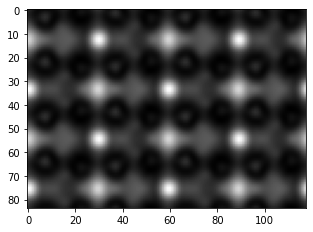

In [36]:
my_array = test_window_images[60]
plt.figure(figsize=(5,5))
plt.imshow(my_array, cmap='gray')
plt.show()

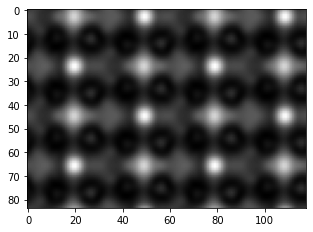

In [37]:
my_array = test_window_images[20]
plt.figure(figsize=(5,5))
plt.imshow(my_array, cmap='gray')
plt.show()

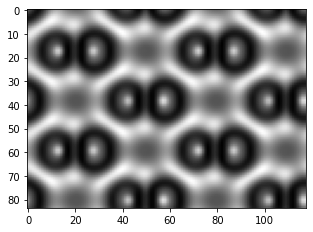

In [38]:
my_array = train_window_images[60]
plt.figure(figsize=(5,5))
plt.imshow(my_array, cmap='gray')
plt.show()

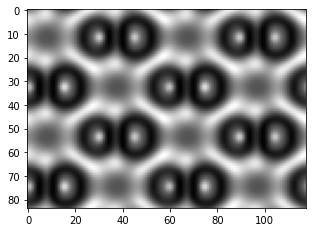

In [39]:
my_array = train_window_images[20]
plt.figure(figsize=(5,5))
plt.imshow(my_array, cmap='gray')
plt.show()

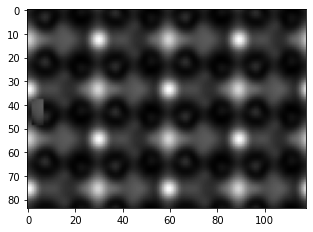

In [40]:
my_array = defect_test_window_images[60]
plt.figure(figsize=(5,5))
plt.imshow(my_array, cmap='gray')
plt.show()

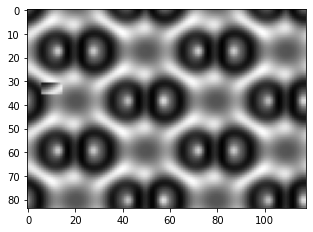

In [41]:
my_array = defect_train_window_images[60]
plt.figure(figsize=(5,5))
plt.imshow(my_array, cmap='gray')
plt.show()

In [15]:
test_full_arrays.keys()

dict_keys(['GaAs_10nm_002', 'GaAs_10nm_017', 'GaAs_10nm_014', 'GaAs_10nm_011', 'GaAs_10nm_005', 'GaAs_10nm_008', 'GaAs_10nm_020', 'GaAs_1nm_011', 'GaAs_1nm_005', 'GaAs_1nm_014', 'GaAs_1nm_002', 'GaAs_1nm_017', 'GaAs_1nm_020', 'GaAs_1nm_008', 'GaAs_6nm_014', 'GaAs_6nm_017', 'GaAs_6nm_002', 'GaAs_6nm_011', 'GaAs_6nm_005', 'GaAs_6nm_020', 'GaAs_6nm_008', 'GaAs_2nm_008', 'GaAs_2nm_020', 'GaAs_2nm_011', 'GaAs_2nm_005', 'GaAs_2nm_014', 'GaAs_2nm_017', 'GaAs_2nm_002', 'GaAs_8nm_020', 'GaAs_8nm_008', 'GaAs_8nm_002', 'GaAs_8nm_017', 'GaAs_8nm_014', 'GaAs_8nm_005', 'GaAs_8nm_011', 'GaAs_12nm_008', 'GaAs_12nm_020', 'GaAs_12nm_017', 'GaAs_12nm_002', 'GaAs_12nm_014', 'GaAs_12nm_011', 'GaAs_12nm_005', 'GaAs_4nm_020', 'GaAs_4nm_008', 'GaAs_4nm_014', 'GaAs_4nm_002', 'GaAs_4nm_017', 'GaAs_4nm_011', 'GaAs_4nm_005', 'GaAs_15nm_008', 'GaAs_15nm_020', 'GaAs_15nm_011', 'GaAs_15nm_005', 'GaAs_15nm_002', 'GaAs_15nm_017', 'GaAs_15nm_014'])

In [16]:
train_full_arrays.keys()

dict_keys(['GaAs_10nm_016', 'GaAs_10nm_003', 'GaAs_10nm_001', 'GaAs_10nm_015', 'GaAs_10nm_004', 'GaAs_10nm_010', 'GaAs_10nm_013', 'GaAs_10nm_007', 'GaAs_10nm_006', 'GaAs_10nm_012', 'GaAs_10nm_021', 'GaAs_10nm_009', 'GaAs_10nm_019', 'GaAs_10nm_018', 'GaAs_1nm_013', 'GaAs_1nm_007', 'GaAs_1nm_006', 'GaAs_1nm_012', 'GaAs_1nm_004', 'GaAs_1nm_010', 'GaAs_1nm_001', 'GaAs_1nm_015', 'GaAs_1nm_016', 'GaAs_1nm_003', 'GaAs_1nm_019', 'GaAs_1nm_018', 'GaAs_1nm_009', 'GaAs_1nm_021', 'GaAs_6nm_001', 'GaAs_6nm_015', 'GaAs_6nm_003', 'GaAs_6nm_016', 'GaAs_6nm_006', 'GaAs_6nm_012', 'GaAs_6nm_013', 'GaAs_6nm_007', 'GaAs_6nm_004', 'GaAs_6nm_010', 'GaAs_6nm_009', 'GaAs_6nm_021', 'GaAs_6nm_018', 'GaAs_6nm_019', 'GaAs_2nm_018', 'GaAs_2nm_019', 'GaAs_2nm_021', 'GaAs_2nm_009', 'GaAs_2nm_006', 'GaAs_2nm_012', 'GaAs_2nm_013', 'GaAs_2nm_007', 'GaAs_2nm_004', 'GaAs_2nm_010', 'GaAs_2nm_001', 'GaAs_2nm_015', 'GaAs_2nm_003', 'GaAs_2nm_016', 'GaAs_8nm_009', 'GaAs_8nm_021', 'GaAs_8nm_019', 'GaAs_8nm_018', 'GaAs_8nm_016',